**Mapping the potential supratidal extent of Australia**

Python imports and configuration settings that set up various libraries and tools for geospatial and environmental data analysis.

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import sys
sys.path.insert(1, "/home/jovyan/dea-notebooks/Tools")
import datacube
dc = datacube.Datacube()
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from dea_tools.landcover import plot_land_cover

### Tide modelling tools
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats

### Virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

### Unused
#import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)
#import pandas as pd
#import numpy as np

Importing and visualizing a GeoJSON file which contains a grid of tiles over coastal regions Australia. 


**Select the desired tile in this map where you want to create a map with supratidal forests**

In [11]:
# Defining a file path
vector_file = './geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

# Load the file and create new GeoDataFrame
gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

# Collecting the 'id' values of each 'mainland' feature
id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
    
# Visualizing 
mainland_grid.explore()

Extraction and visualization of the desired tile

**Insert the id of the selected tile**

In [18]:
# Filtering a certain tile based on its id
gdf = mainland_grid.loc[mainland_grid['id'] == 280]

# Visualizing
gdf.explore()

The purpose of this query dictionary is to define the parameters that will be used when querying or accessing geospatial data

In [19]:
# Repeat the year to select only a single year
time_range = ("2020", "2020")

# Define the resolution
res = (-30, 30)

# Create the 'query' dictionary object
query = {
    "time": time_range,
    'resolution':res}

Preparing a query dictionary for geospatial data analysis, where each feature's geometry is added as a spatial filter to the query and creating a simplified query dictionary "query_notime" that excludes time-related parameters

In [20]:
# Loop through polygons in geodataframe and add geometries to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 280/1


Importing a time series of Landsat 8 observations as an xarray.Dataset

Link to the product: https://explorer.sandbox.dea.ga.gov.au/products/ga_ls8c_ard_3

In [21]:
# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=["ga_ls8c_ard_3"],
              min_gooddata=0.9,
              mask_filters=[("opening", 5), ("dilation", 5)],
              ls7_slc_off=False,
              **query)

# Print output data
ds

Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 5 out of 66 time steps with at least 90.0% good quality pixels
Applying morphological filters to pixel quality mask: [('opening', 5), ('dilation', 5)]
Applying fmask pixel quality/cloud mask
Loading 5 time steps


/home/jovyan/Tools/dea_tools/datahandling.py:492: UserWarning: As of `dea_tools` v0.3.0, pixel quality masks are inverted before being passed to `mask_filters` (i.e. so that good quality/clear pixels are False and poor quality pixels/clouds are True). This means that 'dilation' will now expand cloudy pixels, rather than shrink them as in previous versions.
  warnings.warn(


<xarray.Dataset>
Dimensions:                     (time: 5, y: 3201, x: 3201)
Coordinates:
  * time                        (time) datetime64[ns] 2020-02-01T23:50:22.661...
  * y                           (y) float64 -3.84e+06 -3.84e+06 ... -3.936e+06
  * x                           (x) float64 1.632e+06 1.632e+06 ... 1.728e+06
    spatial_ref                 int32 3577
Data variables: (12/22)
    nbart_coastal_aerosol       (time, y, x) float32 650.0 599.0 ... nan nan
    nbart_blue                  (time, y, x) float32 782.0 732.0 ... nan nan
    nbart_green                 (time, y, x) float32 1.083e+03 1.028e+03 ... nan
    nbart_red                   (time, y, x) float32 1.445e+03 1.364e+03 ... nan
    nbart_nir                   (time, y, x) float32 2.273e+03 2.168e+03 ... nan
    nbart_swir_1                (time, y, x) float32 3.437e+03 3.072e+03 ... nan
    ...                          ...
    oa_satellite_view           (time, y, x) float32 1.249 1.246 ... nan nan
    oa_solar_azimuth            (time, y, x) float32 71.13 71.13 ... nan nan
    oa_solar_zenith             (time, y, x) float32 36.39 36.39 ... nan nan
    oa_time_delta               (time, y, x) float32 -7.518 -7.519 ... nan nan
    oa_fmask                    (time, y, x) uint8 1 1 1 1 1 1 1 ... 0 0 0 0 0 0
    oa_nbart_contiguity         (time, y, x) uint8 1 1 1 1 1 1 1 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

The "tidal_stats" function helps to assess how the range of tides observed by satellites matches the complete tidal range. It achieves this by utilizing the tidal model (FES2014) to predict tide heights at regular intervals (typically every two hours) throughout the entire time span covered by the satellite dataset. These predictions are then compared to the actual tide heights observed by the satellite

A single tide height for each satellite image is modeled, using the centroid of the image as a tide modeling location! If there are zero time steps with at least 90% good quality pixels (see previous code box) available, the tidal model will return the following statement: "**ValueError**: Tides could not be modeled for dataset centroid located at **X**, **Y**. This can occur if this coordinate occurs over land. Please manually specify a tide modeling location located over water using the `tidepost_lat` and `tidepost_lon` parameters." However, the modeling of the tides works for tiles where the centroid is over land and at least one time step is available. 

In the plot below with the modeled and observed tides, a certain offset can be seen. This is due to the few available data points or observed tides (and this is related to the quality criterion when loading the data from Landsat 8). Therefore, the modeled tides should represent the results closest to reality

Setting tide modelling location from dataset centroid: 150.43, -34.50
Modelling tides using FES2014
Modelling tides using FES2014

46% of the 1.78 m modelled astronomical tidal range is observed at this location.
The lowest 27% and highest 27% of astronomical tides are never observed.



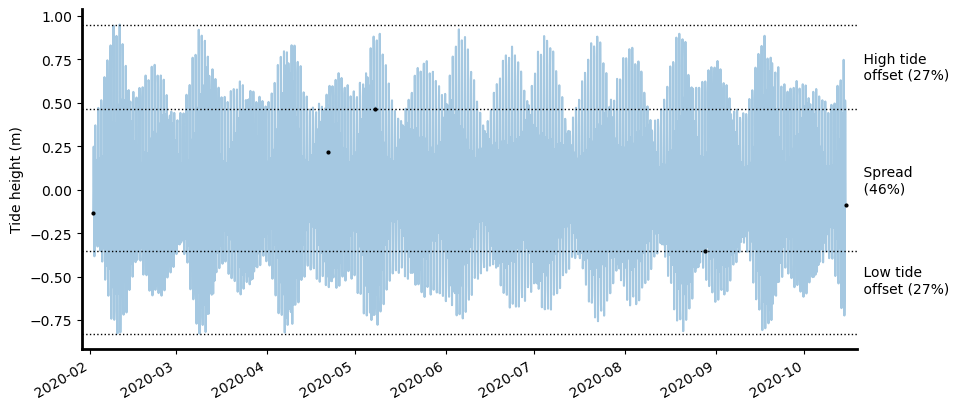

In [22]:
out_stats = tidal_stats(ds)

# Save the figure as a PNG file in the current directory
#plt.savefig('tides_over_time.png', dpi=300, format='png', bbox_inches='tight')

Providing statistics that compare the observed vs. full modeled tidal ranges

In [8]:
out_stats

tidepost_lat        -33.523
tidepost_lon        151.310
observed_mean_m       0.324
all_mean_m            0.000
observed_min_m        0.023
all_min_m            -0.848
observed_max_m        0.765
all_max_m             0.988
observed_range_m      0.742
all_range_m           1.837
spread                0.404
low_tide_offset       0.474
high_tide_offset      0.121
dtype: float64

With the help of the provided stats above, one can calculate the ratio between the modeled and observed maximum tide

In [9]:
Factor = out_stats.all_max_m / out_stats.observed_max_m
print('The factor beteween the modeled and observed maximum tide is =', round(Factor, 2))

The factor beteween the modeled and observed maximum tide is = 1.29


**One can now add a certain 'Extra_height' [m] to the maximum modeled or observed tide as well as multiply it with a certain 'Factor' [-].**

In [18]:
# Define the added added height [m] and/or multiplied factor [-]
Extra_height = 5
Factor = 10

# Calculation of the added / multiplied modeled height
Mod_height1 = out_stats.all_max_m + Extra_height
Mod_height2 = out_stats.all_max_m * Factor

# Calculation of the added / multiplied observed height
Obs_height1 = out_stats.observed_max_m + Extra_height
Obs_height2 = out_stats.observed_max_m * Factor

print('The added height is =', round(Mod_height1, 2), '(max modeled tide)') 
print('The multiplied height is =', round(Mod_height2, 2), '(max modeled tide)') 
print()
print('The added height is =', round(Obs_height1, 2), '(max observed tide)') 
print('The multiplied height is =', round(Obs_height2, 2), '(max observed tide)') 

The added height is = 5.99 (max modeled tide)
The multiplied height is = 9.88 (max modeled tide)

The added height is = 5.76 (max observed tide)
The multiplied height is = 7.65 (max observed tide)


The maximum modeled height represents the lower end of the extent of the supratidal zone (Min_STZ)

The maximum modeled height multiplied with a certain factor represents the upper end of the extent of the supratidal zone (Max_STZ)

In [19]:
Max_STZ = Mod_height2 
Min_STZ = out_stats.all_max_m

print('The extent of the supratidal zone ranges between', round(out_stats.all_max_m, 2), 'm and', round(Mod_height2, 2), 'm (above sea level)') 

The extent of the supratidal zone ranges between 0.99 m and 9.88 m (above sea level)


Loading various datasets / products using the datacube (dc) library

Here you can see the product catalogue: https://explorer.sandbox.dea.ga.gov.au/products

In [20]:
# Load STRM (Shuttle Radar Topography Mission) DEM (Digital elevation model)
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h


# Load item_v2 (Intertidal extents model)
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative


# Load mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

Load in woody cover virtual product

In [21]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

In [22]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [23]:
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)

# # woody cover with threshold for saltmarsh
woody_cover = xr.where(woody_cover_vp.woody_cover > 0.5, 1, 0).astype('int8')
woody_cover.attrs['crs'] = 'EPSG:3577'

/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Processing of binary maps for mangroves, AHD (Australian height datum) elevation thresholds, and intertidal areas, ensuring they have the desired "True" and "False" values. Removal of time dimension from these maps

In [24]:
### Wrangle binary maps and create STF (Supratidal forests) mask

# Not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1


# Greater than Min_STZ and less than Max_STZ == True
AHD_min = Min_STZ
AHD_max = Max_STZ

# SRTM elevation thresholds
Upper_threshold_AHD = srtm <= AHD_max
Lower_threshold_AHD = srtm >= AHD_min
AHD_threshold_srtm = Upper_threshold_AHD & Lower_threshold_AHD


# Item_v2 (remove all intertidal areas)
not_intertidal = item == 9


# Remove time dimension
not_mangrove = not_mangrove.squeeze('time')
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

Individual visualization of all created binary maps

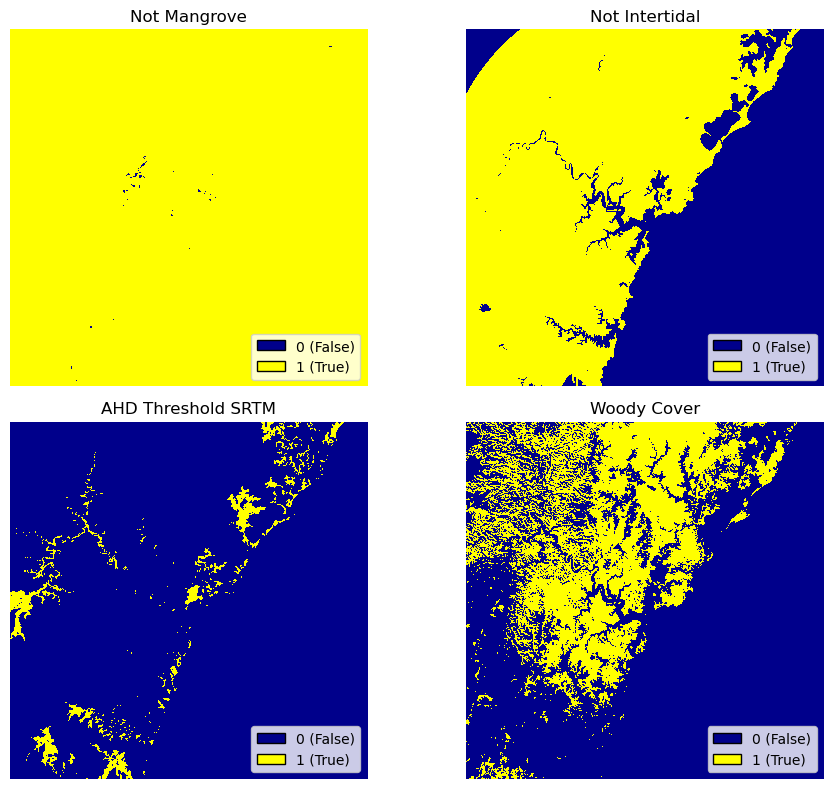

In [25]:
# Assuming you have four binary masks in a list with titles
binary_masks = [not_mangrove, not_intertidal, AHD_threshold_srtm, woody_cover]

# Assuming you have a separate list of names for the subplots
subplot_names = ['Not Mangrove', 'Not Intertidal', 'AHD Threshold SRTM', 'Woody Cover']

# Calculate the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 2
num_subplots = num_rows * num_cols

# Create Figure and Axes objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Flatten the axs array to iterate through the subplots
axs = axs.flatten()

# Define the custom colormap for yellow and blue
cmap = plt.cm.colors.ListedColormap(['darkblue', 'yellow'])

# Iterate through your binary masks and plot them
for i in range(num_subplots):
    if i < len(binary_masks):
        binary_mask = binary_masks[i]
        ax = axs[i]
        
        # Use the custom colormap
        ax.imshow(binary_mask, cmap=cmap, vmin=0, vmax=1)
        
        if i < len(subplot_names):
            ax.set_title(subplot_names[i])  # Take title from the separate list
        ax.axis('off')

# Create artificial legends
legend_elements = [Patch(facecolor='darkblue', edgecolor='black', label='0 (False)'),
                   Patch(facecolor='yellow', edgecolor='black', label='1 (True)')]

# Add the legend to each subplot
for ax in axs:
    ax.legend(handles=legend_elements, loc='lower right')

# Adjust layout, save the figure and display the subplots
plt.tight_layout()
#plt.savefig('binary_maps.png', dpi=300, format='png', bbox_inches='tight', transparent=True, facecolor='white')
plt.show()  # Diese Zeile hinzufügen, um die Abbildung anzuzeigen

Creation of a new binary map called "STF", based on certain conditions applied to three existing binary maps

(not_mangrove, AHD_threshold_srtm, not_intertidal, woody_cover)

In [26]:
### Combine masks

### AHD_threshold
#STF = xr.where((AHD_threshold_srtm == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove
#STF = xr.where((AHD_threshold_srtm == False) + (not_mangrove == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove + not_intertidal
#STF = xr.where((AHD_threshold_srtm == False) + (not_mangrove == False) + (not_intertidal == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove + woody_cover
#STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (woody_cover == False), 0, 1).astype('int8')

### AHD_threshold + not_intertidal + woody_cover
#STF = xr.where((AHD_threshold_srtm == False) + (not_intertidal == False) + woody_cover, 0, 1).astype('int8')

### Not_mangrove + AHD_threshold + not_intertidal + woody_vegetation_mask
STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')

Generating a polygon mask to retain only the data within a specified polygon defined by the "gdf" GeoDataFrame

The result is that the "STF" dataset is now limited to only those pixels that are inside the polygon, and all other pixels have been masked out (set to NaN).

In [27]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
STF = STF.where(mask)

Visualization of the data

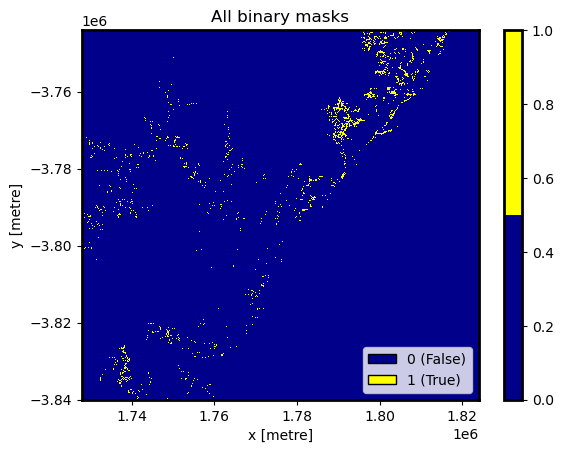

In [28]:
# Create the plot
STF.plot(cmap = cmap)

# Set the title
plt.title("All binary masks")

# Define the custom colormap for yellow and blue
cmap = plt.cm.colors.ListedColormap(['darkblue', 'yellow'])

# Create artificial legends
legend_elements = [Patch(facecolor='darkblue', edgecolor='black', label='0 (False)'),
                   Patch(facecolor='yellow', edgecolor='black', label='1 (True)')]

plt.legend(handles=legend_elements, loc='lower right')

# Display the plot and save the figure
#plt.savefig('STF_map.png', dpi=300, format='png', bbox_inches='tight', transparent=True, facecolor='white')
plt.show() 

Output to GeoTIFF

In [22]:
# Set all pixels with a value of 0 to NaN
STF_black = STF.where(STF == 1, other=np.nan)

# Specify the output path for the GeoTIFF file
output_path = 'STF_map_ID_'+ gdf['id'].astype(str).item() +'_year_' + time_range[0] + '.tif'

# Save the modified DataArray as a GeoTIFF file
#STF_black.rio.to_raster(output_path)